In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import os, sys, datetime, time, random, fnmatch, math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage.metrics

import torch
from torchvision import transforms as tvtransforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.utils as vutils
import torch.utils.tensorboard as tensorboard
import torch.nn as nn

import datasets, transforms, GusarevModel, pytorch_msssim

flag_debug = False
flag_load_previous_save = False

# Input Directories
#data_BSE = "D:/data/JSRT/BSE_JSRT"
#data_normal = "D:/data/JSRT/JSRT"
data_BSE = "G:/DanielLam/JSRT/augmented/train/target"
data_normal = "G:/DanielLam/JSRT/augmented/train/source"

# Save directories:
output_save_directory = Path("./runs/6LayerCNN/v6_GusarevCanonical")
output_save_directory.mkdir(parents=True, exist_ok=True)
PATH_SAVE_NETWORK_INTERMEDIATE = os.path.join(output_save_directory, 'network_intermediate.tar' )
PATH_SAVE_NETWORK = os.path.join(output_save_directory, 'network_final.pt')

# Image Size:
image_spatial_size = (256 , 256)
_batch_size = 5
test_length = 10

# Optimisation
lr_ini = 0.001 
beta1 = 0.9
beta2 = 0.999

# Training
num_reals_per_epoch_paper = 4000 # in Gusarev et al. 2017
total_num_epochs_paper = 150
num_epochs_decay_lr_paper = 100
lr_decay_ratio = 0.25

# Weight Initialisation
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0., 0.02)
        #nn.init.kaiming_normal_(m.weight.data,0)
        try:
            nn.init.constant_(m.bias.data, 0.)
        except:
            pass
    if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.InstanceNorm2d):
        if m.affine:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0.)

## Code for putting things on the GPU
ngpu = 1 #torch.cuda.device_count()
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
print(torch.cuda.get_device_name(torch.cuda.current_device()))

cuda
GeForce RTX 2080 Ti


(3990, 10)


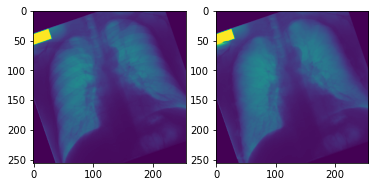

In [2]:
# Current date:
current_date=datetime.datetime.today().strftime('%Y-%m-%d')

# Data Loader
discriminator_keys_images = ["source", "boneless"]
target_key = "boneless"
ds = datasets.JSRT_CXR(data_normal, data_BSE,
                         transform=tvtransforms.Compose([
                             transforms.RescalingNormalisation(discriminator_keys_images,(0,1)),
                             transforms.RandomIntensityComplement(discriminator_keys_images, probability=0.5),
                             transforms.Rescale(image_spatial_size, discriminator_keys_images, None),
                             transforms.ToTensor(discriminator_keys_images),
                             ])
                      )

# SPLIT DATA INTO TRAINING/VALIDATION SET
lengths=(len(ds)-test_length, test_length)
print(lengths)
ds_training, ds_val = torch.utils.data.random_split(ds, lengths)

dl_training = DataLoader(ds_training, batch_size=_batch_size,
                         shuffle=True, num_workers=0)

dl_validation = DataLoader(ds_val, batch_size=1,
                         shuffle=False, num_workers=0)
fixed_val_sample = next(iter(dl_validation))

fig, ax = plt.subplots(1,2)
ax[0].imshow(fixed_val_sample["source"][0,0,:])
ax[1].imshow(fixed_val_sample["boneless"][0,0,:])
plt.show()

In [3]:
## Implementation of network and losses
input_array_size = (_batch_size, 1, image_spatial_size[0], image_spatial_size[1])
net = GusarevModel.MultilayerCNN_6LayerCNN_v2(input_array_size)
# Initialise weights
net.apply(weights_init)

# Multi-GPU
if (device.type == 'cuda') and (ngpu > 1):
    print("Neural Net on GPU")
    net = nn.DataParallel(net, list(range(ngpu)))
net = net.to(device)

# Optimiser
optimizer = torch.optim.Adam(net.parameters(), lr=lr_ini, betas=(beta1, beta2))

# Learning Rate Scheduler
epoch_factor = round(num_reals_per_epoch_paper/len(ds_training)) # need to have this factor as many epochs as that described in the paper
print("Epoch Factor: "+str(epoch_factor))
total_num_epochs = total_num_epochs_paper*epoch_factor
num_epochs_decay_lr = num_epochs_decay_lr_paper*epoch_factor

lambda_rule = lambda epoch: 1*((1-lr_decay_ratio)**(epoch//num_epochs_decay_lr))

#print(optimizer.state_dict)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule, verbose=True)

# Gusarev Loss
def criterion_MSELoss(testImage, referenceImage):
    mse = nn.MSELoss()
    mse_loss = mse(testImage, referenceImage)
    return mse_loss, mse_loss, torch.zeros(1)
def criterion_Gusarev(testImage, referenceImage, alpha=0.84):
    """
    Gusarev et al. 2017. Deep learning models for bone suppression in chest radiographs.  IEEE Conference on Computational Intelligence in Bioinformatics and Computational Biology.
    """
    mse = nn.MSELoss() # L2 used for easier optimisation c.f. L1
    mse_loss = mse(testImage, referenceImage)
    msssim = pytorch_msssim.MSSSIM(window_size=11, size_average=True, channel=1, normalize='relu')
    msssim_loss = 1 - msssim(testImage, referenceImage)
    total_loss = (1-alpha)*mse_loss + alpha*msssim_loss
    return total_loss, mse_loss, msssim_loss

Using 6-Layer MultiCNN Model.
Epoch Factor: 1
Adjusting learning rate of group 0 to 1.0000e-03.


In [ ]:
# Training
img_list = []
loss_list = []
reals_shown = []
epochs_list = []
ssim_val_list=[]
ssim_training_list=[]
training_loss_per_epoch_list = []
validation_loss_per_epoch_list = []

# For each epoch
print(target_key)

# optionally resume from a checkpoint
if flag_load_previous_save:
    if os.path.isfile(PATH_SAVE_NETWORK_INTERMEDIATE):
        print("=> loading checkpoint '{}'".format(PATH_SAVE_NETWORK_INTERMEDIATE))
        checkpoint = torch.load(PATH_SAVE_NETWORK_INTERMEDIATE)
        start_epoch = checkpoint['epoch_next']
        reals_shown_now = checkpoint['reals_shown']
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("=> loaded checkpoint '{}' (epoch {}, reals shown {})".format(PATH_SAVE_NETWORK_INTERMEDIATE, 
                                                                            start_epoch, reals_shown_now))
        print(scheduler)
    else:
        print("=> NO CHECKPOINT FOUND AT '{}'" .format(PATH_SAVE_NETWORK_INTERMEDIATE))
        raise RuntimeError("No checkpoint found at specified path.")
else:
    print("FLAG: NO CHECKPOINT LOADED.")
    reals_shown_now = 0
    start_epoch=0

# Loop variables
flag_break = False # when debugging, this will automatically go to True
iters = 0
net.train()
for param in net.parameters():
    param.requires_grad = True
for epoch in range(start_epoch, total_num_epochs):
    print(scheduler.get_last_lr())
    for i, data in enumerate(dl_training):
        # Training
        net.zero_grad()
        noisy_data = data["source"].to(device)
        cleaned_data = net(noisy_data)
        loss, mseloss, msssim_loss = criterion_Gusarev(cleaned_data, data[target_key].to(device))
        loss.backward() # calculate gradients
        optimizer.step() # optimiser step along gradients
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tTotal Loss: %.4f\tMSELoss: %.4f\tMSSSIM Loss: %.4f'
                  % (epoch, total_num_epochs, i, len(dl_training),
                     loss.item(), mseloss.item(), msssim_loss.item()))
        # Record generator output
        if reals_shown_now%(100*_batch_size)==0:
            with torch.no_grad():
                val_cleaned = net(fixed_val_sample["source"].to(device)).detach().cpu()
            print("Printing to img_list")
            img_list.append(vutils.make_grid(val_cleaned, padding=2, normalize=True))
        iters +=1
        reals_shown_now += _batch_size
        reals_shown.append(reals_shown_now)
        loss_list.append(loss.item())
        
        if flag_debug and iters>=10:
            flag_break = True
            break
    # Training and Validation Loss and Accuracy
    with torch.no_grad():
        # Training
        noisy_training_data = data["source"][0:1,:].to(device)
        true_training_data = data[target_key][0:1,:]
        cleaned_training_data = net(noisy_training_data)
        loss, maeloss, msssim_loss = criterion_Gusarev(cleaned_training_data, true_training_data.to(device))
        training_loss_per_epoch_list.append(loss.item())
        
        clean_training_numpy = cleaned_training_data.cpu().detach().numpy()[0,:]
        true_training_numpy = true_training_data.numpy()[0,:]
        clean_training_numpy = np.moveaxis(clean_training_numpy, 0, -1)
        true_training_numpy = np.moveaxis(true_training_numpy, 0, -1)
        ssim_training = skimage.metrics.structural_similarity(clean_training_numpy, true_training_numpy, multichannel=True)
        ssim_training_list.append(ssim_training)
        
        # Validation
        sample = next(iter(dl_validation))
        noisy_val_data = sample["source"][0:1,:].to(device)
        true_val_data = sample[target_key][0:1,:]
        cleaned_val_data = net(noisy_val_data)
        val_loss, maeloss, msssim_loss = criterion_Gusarev(cleaned_val_data, true_val_data.to(device))
        validation_loss_per_epoch_list.append(val_loss.item())
        
        clean_val_numpy = cleaned_val_data.cpu().detach().numpy()[0,:]
        true_val_numpy = true_val_data.numpy()[0,:]
        clean_val_numpy = np.moveaxis(clean_val_numpy, 0, -1)
        true_val_numpy = np.moveaxis(true_val_numpy, 0, -1)
        ssim_val = skimage.metrics.structural_similarity(clean_val_numpy, true_val_numpy, multichannel=True)
        ssim_val_list.append(ssim_val)
    
    epochs_list.append(epoch)
    # LR Scheduler
    scheduler.step()
    
    # Save the network in indications
    if epoch % 5 == 0:
        if not flag_debug:
            #torch.save(net.state_dict(), PATH_SAVE_NETWORK_INTERMEDIATE)
            torch.save({
            'epochs_completed': epoch+1,
            'epoch_next': epoch+1,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler_state_dict': scheduler.state_dict(),
            'reals_shown': reals_shown_now
            }, PATH_SAVE_NETWORK_INTERMEDIATE)
            print("Saved Intermediate: "+ str(PATH_SAVE_NETWORK_INTERMEDIATE))
    if flag_break:
        break

if not flag_debug:
    torch.save(net.state_dict(), PATH_SAVE_NETWORK)

boneless
FLAG: NO CHECKPOINT LOADED.
[0.001]
[0/150][0/798]	Total Loss: 0.5315	MSELoss: 0.1010	MSSSIM Loss: 0.6135
Printing to img_list
[0/150][50/798]	Total Loss: 0.2624	MSELoss: 0.0603	MSSSIM Loss: 0.3009
[0/150][100/798]	Total Loss: 0.1227	MSELoss: 0.0869	MSSSIM Loss: 0.1295
Printing to img_list
[0/150][150/798]	Total Loss: 0.1201	MSELoss: 0.0980	MSSSIM Loss: 0.1243
[0/150][200/798]	Total Loss: 0.0945	MSELoss: 0.0328	MSSSIM Loss: 0.1062
Printing to img_list
[0/150][250/798]	Total Loss: 0.1175	MSELoss: 0.0952	MSSSIM Loss: 0.1217
[0/150][300/798]	Total Loss: 0.1256	MSELoss: 0.1241	MSSSIM Loss: 0.1259
Printing to img_list
[0/150][350/798]	Total Loss: 0.0747	MSELoss: 0.0713	MSSSIM Loss: 0.0754
[0/150][400/798]	Total Loss: 0.1143	MSELoss: 0.0858	MSSSIM Loss: 0.1198
Printing to img_list
[0/150][450/798]	Total Loss: 0.0834	MSELoss: 0.0662	MSSSIM Loss: 0.0867
[0/150][500/798]	Total Loss: 0.0868	MSELoss: 0.0705	MSSSIM Loss: 0.0898
Printing to img_list
[0/150][550/798]	Total Loss: 0.1115	MSEL

In [ ]:
print("Training complete")

# CHECKPOINT SAVE
PATH_SAVE_NETWORK_INTERMEDIATE = os.path.join(output_save_directory, 'network_intermediate.tar' )
torch.save({
            'epochs_completed': epoch+1,
            'epoch_next': epoch+1,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler_state_dict': scheduler.state_dict(),
            'reals_shown': reals_shown_now
            }, PATH_SAVE_NETWORK_INTERMEDIATE)
print("Saved Checkpoint '{}' at epoch {}".format(PATH_SAVE_NETWORK_INTERMEDIATE, epoch+1))

In [ ]:
%matplotlib inline
current_date=datetime.datetime.today().strftime('%Y-%m-%d')

# Loss for training
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(reals_shown, loss_list)
plt.xlabel("reals_shown")
plt.ylabel("Loss")
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "training_loss"+".png"))

# Final Model:
with torch.no_grad():
    input_image = fixed_val_sample['source']
    input_images = vutils.make_grid(input_image[0:1,:,:,:], padding=2, normalize=True)
    target_images = vutils.make_grid(fixed_val_sample['boneless'][0:1,:,:,:], padding=2, normalize=True)
    net = net.cpu()
    output_image = net(input_image[0:1,:,:,:]).detach().cpu()
    output_images = vutils.make_grid(output_image, padding=2, normalize=True)
print(str(torch.max(output_images)) + "," + str(torch.min(output_images)))
plt.figure(1)
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(np.transpose(input_images, (1,2,0)), vmin=0, vmax=1)
ax[0].set_title("Source")
ax[0].axis("off")
ax[1].imshow(np.transpose(output_images, (1,2,0)), vmin=0, vmax=1)
ax[1].set_title("Suppressed")
ax[1].axis("off")
ax[2].imshow(np.transpose(target_images, (1,2,0)), vmin=0, vmax=1)
ax[2].set_title("Ideal Bone-suppressed")
ax[2].axis("off")
plt.show
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "_validation_ComparisonImages"+".png"))

# ANIMATED VALIDATION IMAGE
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.axis("off")
ims = []
training_ims_shown = []
for i, im in enumerate(img_list):
    if i % 50 == 0:  # controls how many images are printed into the animation
        training_ims_shown = i*(100*_batch_size)
        frame = ax.imshow(np.transpose(im,(1,2,0)))
        t = ax.annotate("Reals shown: {}".format(training_ims_shown), (0.5,1.02), xycoords="axes fraction")
        ims.append([frame, t])
ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000, blit=True)
if not flag_debug:
    ani.save(os.path.join(output_save_directory, current_date+"_animation.mp4"), dpi=300)

In [ ]:
a = [0,1,2,3,4,5,6,7,8,9]
a[0:-1:3]